In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "jkiani" # username from the json file
os.environ['KAGGLE_KEY'] = "3a97d87c8b542afb21b86593b9d954d4" # key from the json file
#!kaggle datasets download -d iarunava/happy-house-dataset # api copied from kaggle
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 56.9MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.7MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.6MB/s]


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [13]:
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns in train')
print(f'There are {test.shape[0]} rows and {test.shape[1]} columns in test')

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


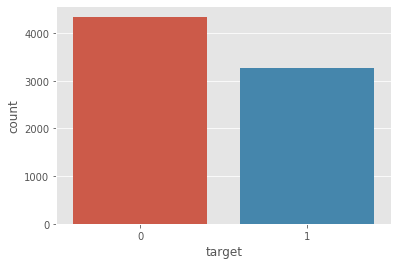

In [14]:
sns.countplot(train['target']);


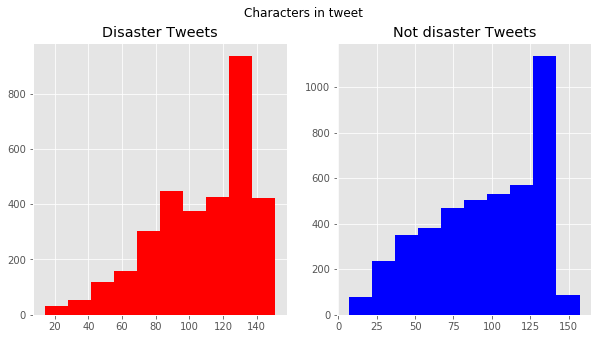

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train.loc[train['target'] == 1, 'text'].str.len()
tweet_len.hist(color = 'r', ax = ax1)
ax1.set_title('Disaster Tweets');
tweet_len = train.loc[train['target'] == 0, 'text'].str.len()
tweet_len.hist(color = 'b', ax = ax2)
ax2.set_title('Not disaster Tweets');
fig.suptitle('Characters in tweet');

Text(0.5, 0.98, 'Words in tweet')

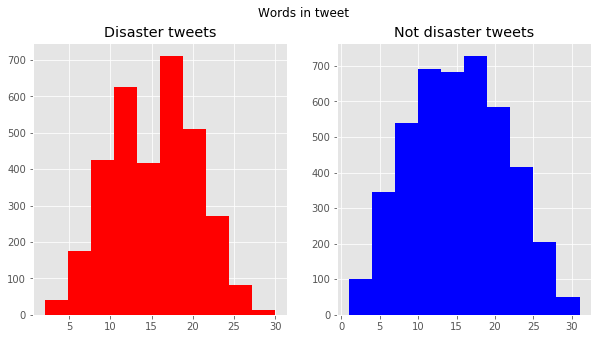

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train.loc[train['target'] == 1, 'text'].str.split().map(lambda x:len(x))
tweet_len.hist(color = 'r', ax = ax1)
ax1.set_title('Disaster tweets')
tweet_len = train.loc[train['target'] == 0, 'text'].str.split().map(lambda x:len(x))
tweet_len.hist(color = 'b', ax = ax2)
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in tweet')

Text(0.5, 0.98, 'Average word length in tweets')

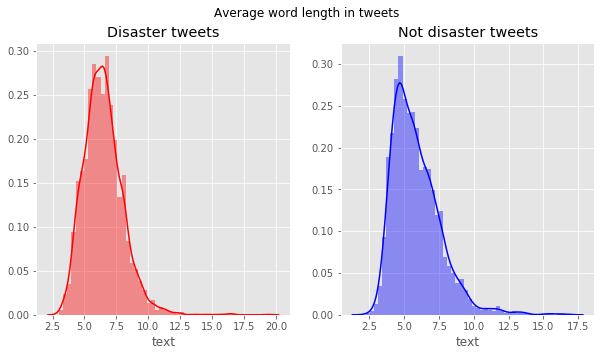

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train.loc[train['target'] == 1, 'text'].str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(tweet_len.map(lambda x:np.mean(x)), ax = ax1, color = 'red')
ax1.set_title('Disaster tweets')
tweet_len = train.loc[train['target'] == 0, 'text'].str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(tweet_len.map(lambda x:np.mean(x)), ax = ax2, color = 'b')
ax2.set_title('Not disaster tweets')
fig.suptitle('Average word length in tweets')

In [0]:
def create_corpus(target):
    corpus = []
    for x in train.loc[train['target'] == target, 'text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
corpus =  create_corpus(0)
dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w] += 1
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]

<BarContainer object of 10 artists>

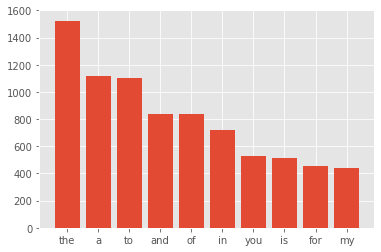

In [20]:
x, y = zip(*top)
plt.bar(x, y)

In [0]:
corpus = create_corpus(1)
dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w] += 1
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]

<BarContainer object of 10 artists>

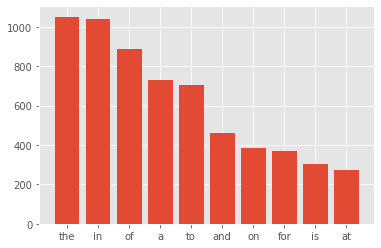

In [22]:
x, y = zip(*top)
plt.bar(x, y)

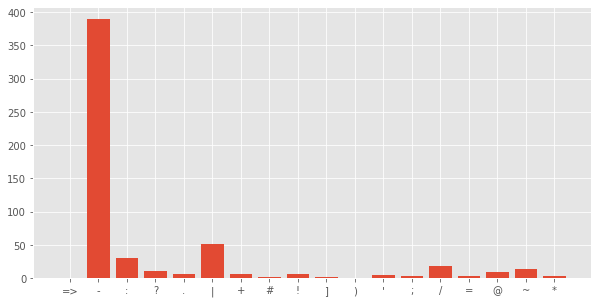

In [23]:
plt.figure(figsize = (10, 5))
corpus = create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y);

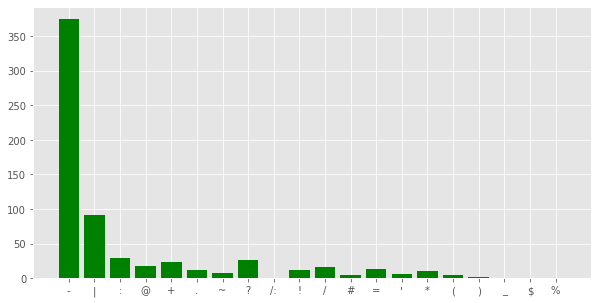

In [24]:
plt.figure(figsize = (10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color = 'g');

In [0]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if not word in stop:
        x.append(word)
        y.append(count)

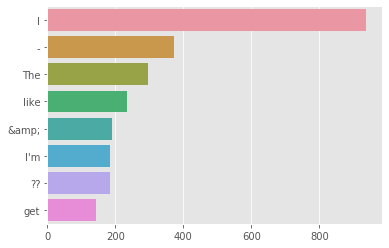

In [26]:
sns.barplot(x = y, y = x)

In [27]:
df = pd.concat([train, test], sort = True)
df.shape

(10876, 5)

In [0]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [30]:
def remove_URL(text):
    url = re.compile('https?://\S+|www\.\S+')
    return url.sub(r'', text)
remove_URL(example)

'New competition launched :'

In [0]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [0]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [33]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
remove_html(example)

'\nReal or Fake\nKaggle \ngetting started\n'

In [0]:
df['text'] = df['text'].apply(lambda x: remove_html(x))


In [35]:
def remove_emoji(text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'',text)
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [0]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [37]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
example="I am a #king"
print(remove_punct(example))


I am a king


In [0]:
df['text'] = df['text'].apply(lambda x:remove_punct(x))

In [0]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
        #words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]

        corpus.append(words)
    return corpus

In [42]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7030.55it/s]


In [44]:
!kaggle datasets download -d jkiani/glove6b100dtxt

 92% 121M/131M [00:03<00:00, 47.1MB/s]
100% 131M/131M [00:03<00:00, 40.3MB/s]


In [0]:
embedding_dict = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = values[1:]
        embedding_dict[word] = vectors
f.close()

In [0]:
Max_len = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=Max_len, truncating = 'post', padding = 'post')

In [0]:
Max_len = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=Max_len, truncating = 'post', padding = 'post')

In [53]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

Number of unique words: 20342


In [54]:
tweet_pad.shape

(10876, 50)

In [55]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 59936.52it/s]


In [64]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=Max_len,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [65]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [0]:
train_x = tweet_pad[:train.shape[0]]
test_X = tweet_pad[train.shape[0]:]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_x,train['target'].values,test_size=0.15)

In [68]:
history = model.fit(X_train, y_train, batch_size=4, epochs = 15, validation_data=(X_test, y_test), verbose = 2)




Train on 6471 samples, validate on 1142 samples
Epoch 1/15





 - 66s - loss: 0.6914 - acc: 0.5715 - val_loss: 0.6906 - val_acc: 0.5499
Epoch 2/15
 - 66s - loss: 0.6842 - acc: 0.5739 - val_loss: 0.6771 - val_acc: 0.5499
Epoch 3/15
 - 65s - loss: 0.6382 - acc: 0.6271 - val_loss: 0.5802 - val_acc: 0.7574
Epoch 4/15
 - 66s - loss: 0.5875 - acc: 0.7221 - val_loss: 0.5390 - val_acc: 0.7758
Epoch 5/15
 - 65s - loss: 0.5669 - acc: 0.7365 - val_loss: 0.5179 - val_acc: 0.7741
Epoch 6/15
 - 65s - loss: 0.5614 - acc: 0.7438 - val_loss: 0.5098 - val_acc: 0.7828
Epoch 7/15
 - 65s - loss: 0.5567 - acc: 0.7413 - val_loss: 0.5061 - val_acc: 0.7890
Epoch 8/15
 - 65s - loss: 0.5464 - acc: 0.7557 - val_loss: 0.4932 - val_acc: 0.7925
Epoch 9/15
 - 65s - loss: 0.5482 - acc: 0.7532 - val_loss: 0.4955 - val_acc: 0.7881
Epoch 10/15
 - 64s - loss: 0.5494 - acc: 0.7509 - val_loss: 0.4894 - val_acc: 0.7925
Epoch 11/15
 - 64s - loss: 0.5446 - acc: 0.7537 - val_loss: 0.4839 - val_acc: 0.7933
Epoch 12/15
 - 64s

In [0]:
y_pred = model.predict(test_X)
y_pred = np.round(y_pred).astype(int).reshape(3263)

sample_submission['target'] = y_pred
sample_submission.to_csv('submission.csv', index = False)

In [70]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:03<00:00, 7.06kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets